In [ ]:
"""
Use movie_data_general_cleaned to build a basic Linear Regression model for general movies.

functions used:
get_Xy(df) from model.py
get_score(X_train,X_val,y_train,y_val) from model.py

"""

In [63]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge, RidgeCV
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import PowerTransformer

import patsy
import scipy.stats as stats

import sys
sys.path.append('/Users/katiehuang/Documents/metis/projects/onl_ds5_project_2/py')
import importlib
from model import *

### Separate columns into target candidates, continuous features, categorical features

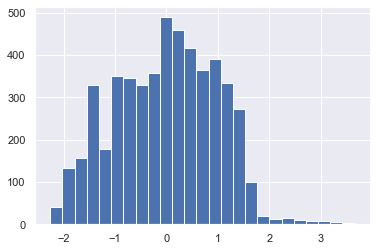

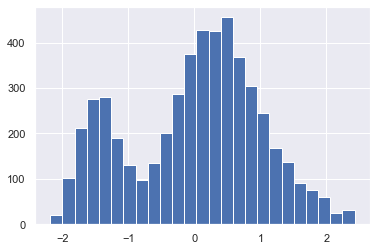

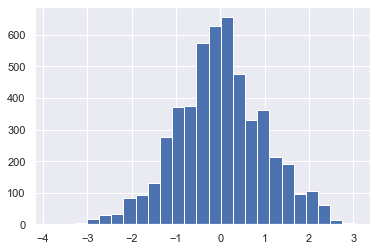

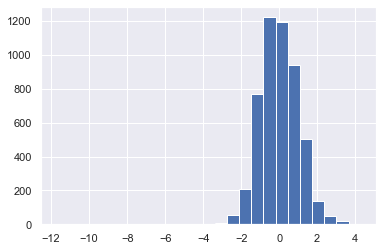

In [120]:
# Load the cleaned complete data
all_df = pd.read_pickle('../data/movie_data_general_cleaned')

# Log transform target variable
all_df['log_opening_weekend_usa'] = np.log(all_df['opening_weekend_usa'])
all_df['log_budget'] = np.log(all_df['budget'])
all_df['log_runtime'] = np.log(all_df['runtime'])
all_df['log_release_year'] = np.log(all_df['release_year'])

# 1/sqrt(target)
all_df['1_sqrt_opening_weekend_usa'] = (all_df['opening_weekend_usa'])**-0.5
all_df['1_sqrt_budget'] = (all_df['budget'])**-0.5

# Try power transform
data = (all_df[['release_year']].apply(lambda x: 2022 - x))
power = PowerTransformer(method='box-cox', standardize=True)
data_trans = power.fit_transform(data)
plt.hist(data_trans, bins=25)
plt.show()
# Create a new column in case needed in the futurre
all_df['T_movie_age'] = data_trans.reshape(len(data),)

data = (all_df[['opening_weekend_usa']])
power = PowerTransformer(method='box-cox', standardize=True)
data_trans = power.fit_transform(data)
plt.hist(data_trans, bins=25)
plt.show()
# Create a new column in case needed in the futurre
all_df['T_opening_weekend_usa'] = data_trans.reshape(len(data),)

data = (all_df[['budget']])
power = PowerTransformer(method='box-cox', standardize=True)
data_trans = power.fit_transform(data)
plt.hist(data_trans, bins=25)
plt.show()
# Create a new column in case needed in the futurre
all_df['T_budget'] = data_trans.reshape(len(data),)

data = (all_df[['runtime']])
power = PowerTransformer(method='box-cox', standardize=True)
data_trans = power.fit_transform(data)
plt.hist(data_trans, bins=25)
plt.show()
# Create a new column in case needed in the futurre
all_df['T_runtime'] = data_trans.reshape(len(data),)

In [121]:
con_feature = ['budget','runtime','release_year']
cat_feature = ['MPAA','genre','distributor','language','country','keywords']
target_candidate = ['opening_weekend_usa','log_opening_weekend_usa','gross_usa','gross_world','rating','vote']

In [122]:
# Choose only the continuous variables for now
c_movie_df = all_df[['opening_weekend_usa'] + con_feature].copy()

### Baseline Model
Only consider the continuous predictors and use 'opening_weekend_usa' as target.

In [123]:
# Use box-cox transform for all variables
df = all_df[['T_opening_weekend_usa','T_budget','T_runtime','T_movie_age']].dropna()
X = df[['T_budget','T_runtime','T_movie_age']]
y = df['T_opening_weekend_usa']

# Separate X, y into train/validation/test sets (60/20/20)
X_, X_test, y_, y_test = train_test_split(X, y, test_size=.2, random_state=20)
X_train, X_val, y_train, y_val = train_test_split(X_, y_, test_size=.25, random_state=21)


Train R^2 score was: 0.45975325935518985
Validation R^2 score was: 0.44163259320204407
RMSE: 0.74 



(0.0, 2.5)

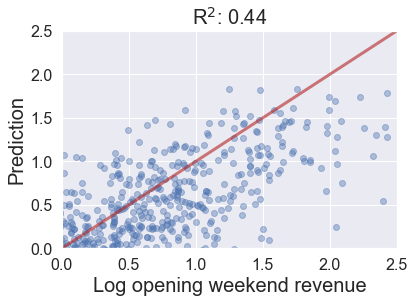

In [124]:
# fit linear regression to training data
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
y_pred = lr_model.predict(X_val)

# score fit model on validation data
train_score = lr_model.score(X_train, y_train)
val_score = lr_model.score(X_val, y_val)
rmse = np.sqrt(mean_squared_error(y_val, y_pred))


# report results
print('\nTrain R^2 score was:', train_score)
print('Validation R^2 score was:', val_score)
print(f'RMSE: {rmse:.2f} \n')

# print('Feature coefficient results:')
# for feature, coef in zip(X.columns, lr_model.coef_):
#     print(feature, ':', f'{coef:.2f}')


# Visualization
fig, ax = plt.subplots(1, 1)
plt.scatter(y_val, y_pred, alpha=0.4)

ax.set_xlabel('Log opening weekend revenue',fontsize=20)
ax.set_ylabel('Prediction',fontsize=20)
ax.set_title('R$^2$: %0.2f' % val_score, fontsize=20)

plt.xticks(fontsize=16)
plt.yticks(fontsize=16)


# x=np.linspace(0,0.7e2,50)
x=np.linspace(0,2.5,50)

y=x
plt.plot(x,y,color='firebrick',linewidth=3,alpha=0.6)
plt.ylim(0,2.5)
plt.xlim(0,2.5)

### Residuals

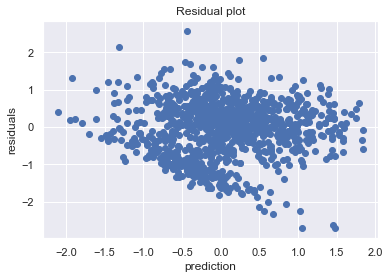

In [125]:
res = y_val - y_pred
plt.scatter(y_pred, res)
plt.title("Residual plot")
plt.xlabel("prediction")
plt.ylabel("residuals");

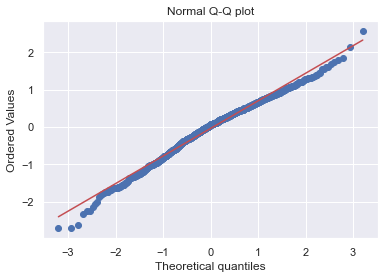

In [126]:
# diagnose/inspect residual normality using qqplot:
stats.probplot(res, dist="norm", plot=plt)
plt.title("Normal Q-Q plot")
plt.show()

In [127]:
# with all variables box-cox transformed, Q-Q plot closer to normal 